----------------

```{admonition} Learning Objectives
* Utilize different vector overlays and understand the differences between each
* Join data based on their geographic location and explore the different join types
```
```{admonition} Review
* [Spatial Vector Data](c_vectors.md)
* [Attributes & Indexing for Vector Data](e_attributes.md)
* [Creating Spatial Vector Data](c_new_vectors.md)
```
----------------

# Spatial Overlays and Joins

Combining two or more datasets together is a fundamental aspect of GIS. Using `geopandas`, we can create new geometries from existing datasets by overlaying them on top of each other, identifying where they do and do not overlap, and deciding what parts we want to extract from these overlays. For each of these new shapes, the attribute data from the existing constituent datasets are also combined together. [^gpd_set], [^bolstad]

In this chapter, we will focus on vector overlays, which involve combining vector data. We'll explore five types of vector overlays and merging: union, intersection, difference (erase), identity, and spatial join.

## Setup

First, let's import the necessary modules (click the + below to show code cell).

In [5]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt

To illustrate these geoprocessing tools, we will utilize shapefiles of San Francisco Bay Area county boundaries, Bay Area watershed boundaries, and wells within the Bay Area and the surrounding 50 km. We will load in the data and reproject the data (click the + below to show code cell).

```{important} All the data must have the same coordinate system in order for extraction to work correctly.
```

In [6]:
# Load data

# County boundaries
# Source: https://opendata.mtc.ca.gov/datasets/san-francisco-bay-region-counties-clipped?geometry=-125.590%2C37.123%2C-119.152%2C38.640
counties = gpd.read_file("../../pygis/_static/e_vector_shapefiles/sf_bay_counties/sf_bay_counties.shp")

# Watershed boundaries
# Source: https://gis.data.ca.gov/datasets/CDFW::epa-surf-your-watershed-ds732?geometry=-128.711%2C36.474%2C-115.835%2C39.504
# Modified by author so that only the watersheds with centroids in the Bay Area counties were kept
watersheds = gpd.read_file("../../pygis/_static/e_vector_shapefiles/sf_bay_watersheds/sf_bay_watersheds.shp")

# Well locations
# Source: https://gis.data.ca.gov/datasets/3a3e681b894644a9a95f9815aeeeb57f_0?geometry=-123.143%2C36.405%2C-119.230%2C37.175
# Modified by author so that only the well locations within the counties and the surrounding 50 km were kept
wells = gpd.read_file("../../pygis/_static/e_vector_shapefiles/sf_bay_wells_50km/sf_bay_wells_50km.shp")

# Reproject data to NAD83(HARN) / California Zone 3
# https://spatialreference.org/ref/epsg/2768/
proj = 2768
counties = counties.to_crs(proj)
watersheds = watersheds.to_crs(proj)
wells = wells.to_crs(proj)

We'll define some functions to make displaying and mapping our results a bit easier (click the + below to show code cell).

In [7]:
def display_table(table_name, attribute_table):
    '''Display the first and last two rows of attribute table.'''

    # Print title
    print("Attribute Table: {}".format(table_name))

    # Print number of rows and columns
    print("\nTable shape (rows, columns): {}".format(attribute_table.shape))

    # Display first two rows of attribute table
    print("\nFirst two rows:")
    display(attribute_table.head(2))

    # Display last two rows of attribute table
    print("\nLast two rows:")
    display(attribute_table.tail(2))


def plot_overlay(overlay_type, overlay_result):
    '''Plot the overlay result on a map and add the outlines of the original shapefiles on top.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Plot overlay data
    overlay_result.plot(ax = ax, cmap = 'Set2', edgecolor = 'black')

    # Plot outlines of original shapefiles
    counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
    watersheds.plot(ax = ax, color = 'none', edgecolor = 'dodgerblue')

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title('San Francisco Bay Area County and Watershed Boundaries\n{}'.format(overlay_type), fontdict = {'fontsize': '15', 'fontweight' : '3'})


def plot_merge(merge_type, merge_result, merge_vector):
    '''Plot the merge result on a map.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Plot data depending on vector type
    # For points
    if merge_vector == "point":

        # Plot data
        counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
        merge_result.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)

    # For polygons
    else:

        # Plot data
        merge_result.plot(ax = ax, cmap = 'Set2', edgecolor = 'black')

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title('San Francisco Bay Area County Boundaries and Well Locations\n{}'.format(merge_type), fontdict = {'fontsize': '15', 'fontweight' : '3'})

## Overlays

For the first four, we can use the `overlay` function in `geopandas`. We simply change the argument for the `how` parameter to the overlay of our choosing.

We will use the county boundaries and watershed boundaries shapefiles in these examples. The overlays will allow us to see what areas are only in a county, only in a watershed, or in both.

Let's briefly examine the attribute table of our shapefiles and plot the data so that we know what we're working with.

Text(0.5, 1.0, 'San Francisco Bay Area County and Watershed Boundaries')

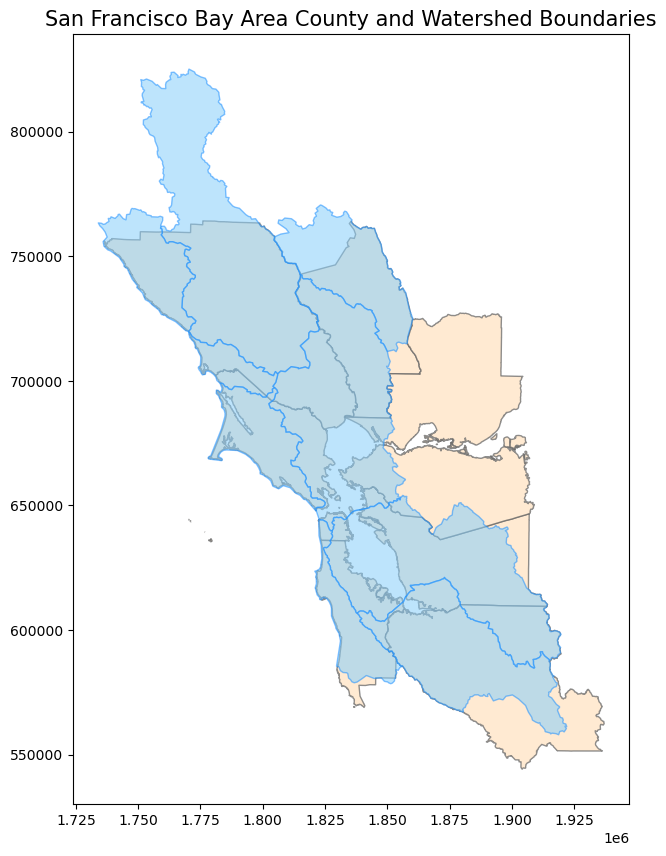

In [8]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray', alpha = 0.75)
watersheds.plot(ax = ax, color = 'lightskyblue', edgecolor = 'dodgerblue', alpha = 0.55)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('San Francisco Bay Area County and Watershed Boundaries', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [9]:
# Print attribute table
display(counties)

,coname,geometry
0,Alameda County,"MULTIPOLYGON (((1860234.837 612219.122, 186007..."
1,Contra Costa County,"MULTIPOLYGON (((1836501.066 656512.837, 183649..."
2,Marin County,"MULTIPOLYGON (((1830493.06 653832.167, 1830505..."
3,Napa County,"POLYGON ((1860171.549 724651.231, 1860170.736 ..."
4,San Francisco County,"MULTIPOLYGON (((1779231.793 635380.766, 177918..."
5,San Mateo County,"MULTIPOLYGON (((1836712.268 569216.86, 1836717..."
6,Santa Clara County,"MULTIPOLYGON (((1858733.082 607586.45, 1858743..."
7,Solano County,"MULTIPOLYGON (((1875491.908 673077.9, 1875491...."
8,Sonoma County,"MULTIPOLYGON (((1746855.532 743026.706, 174685..."


In [10]:
# Print attribute table
display(watersheds)

,CUNAME,geometry
0,RUSSIAN,"POLYGON ((1772952.612 823099.656, 1775209.737 ..."
1,UPPER_PUTAH,"POLYGON ((1825517.283 769282.042, 1826065.366 ..."
2,GUALALA-SALMON,"POLYGON ((1747656.8 769294.908, 1748144.659 76..."
3,SAN_PABLO_BAY,"POLYGON ((1815758.957 741414.318, 1816340.883 ..."
4,BODEGA_BAY,"POLYGON ((1778048.116 714367.855, 1780284.096 ..."
5,TOMALES-DRAKE_BAYS,"POLYGON ((1783925.368 698933.179, 1784977.305 ..."
6,SAN_FRANCISCO_BAY,"POLYGON ((1856614.017 653898.716, 1856857.793 ..."
7,SAN_FRANCISCO_COASTAL_SOUTH,"POLYGON ((1826732.9 640369.438, 1827321.624 63..."
8,COYOTE,"POLYGON ((1875229.662 619208.108, 1875664.986 ..."


### Union

With `how='union'`, all data (all geometries regardless of overlap) is kept. [^gpd_set]

```{figure} ../_static/img/vector_union.jpg
:name: Union of all geometries keeps all data.
Union keeps all the data. In the figure above, all of A and B are kept.
```

Looking at the attribute table, we see that the attributes from both individual datasets have been combined. The areas that are unique to one dataset (no overlap) have `NaN` as values in the fields that originated from the other dataset. [^gpd_set], [^bolstad]

In [11]:
# Get union
union_result = gpd.overlay(counties, watersheds, how = 'union')

# Print head and tail of attribute table
display_table(table_name = "Union", attribute_table = union_result)

Attribute Table: Union

Table shape (rows, columns): (46, 3)

First two rows:


/tmp/ipykernel_1445/3249878955.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union_result = gpd.overlay(counties, watersheds, how = 'union')


,coname,CUNAME,geometry
0,Alameda County,SAN_PABLO_BAY,"POLYGON ((1844333.772 657330.481, 1844341.139 ..."
1,Alameda County,SAN_FRANCISCO_BAY,"MULTIPOLYGON (((1842804.963 642171.499, 184280..."



Last two rows:


,coname,CUNAME,geometry
44,NaN,SAN_FRANCISCO_COASTAL_SOUTH,"MULTIPOLYGON (((1850534.044 591674.474, 185053..."
45,NaN,COYOTE,"MULTIPOLYGON (((1915334.593 586887.473, 191534..."


Next, we can map the data, filling in the areas with color that have been retained. As the plot shows, no data was removed.

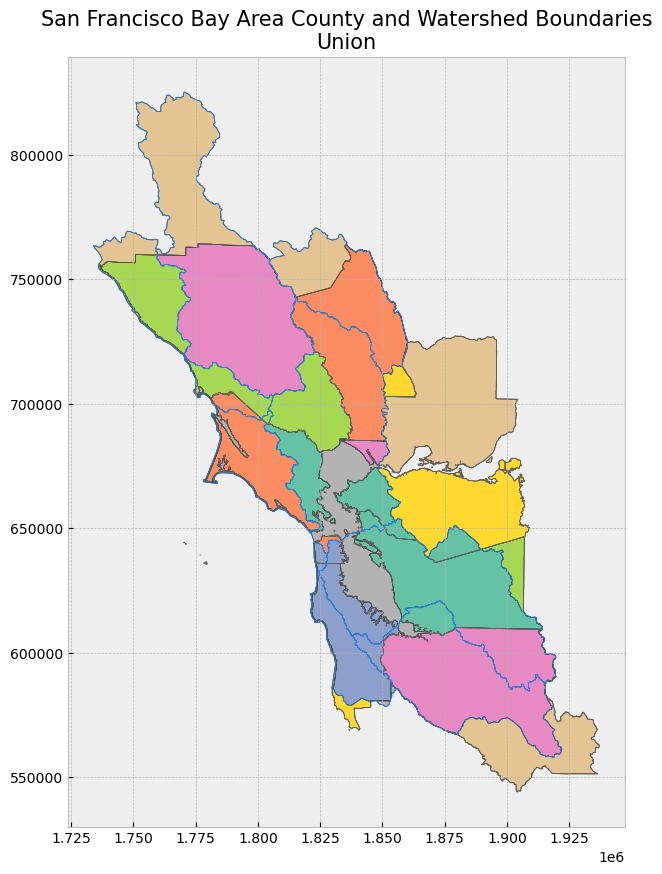

In [12]:
# Plot overlay
plot_overlay(overlay_type = "Union", overlay_result = union_result)

### Intersection

With `how='intersection'`, only the areas where all datasets contain data (have geometries) are combined together. [^gpd_set]

```{figure} ../_static/img/vector_intersection.jpg
:name: Intersection of geometries keeps overlapping geometries.
Intersection keeps the geometries that overlap with each other. In the figure above, only the portion where A and B overlap is kept.
```

Because there are no areas unique to one dataset, notice how the attribute table of the combined dataset does not have any `NaN` values. When mapping the intersection overlay, we can see that any areas that did not have any overlay were discarded (areas with an outline but no fill). Areas covered by the county and watershed boundaries datasets are kept (shown in color). [^gpd_set], [^bolstad]

Attribute Table: Intersection

Table shape (rows, columns): (28, 3)

First two rows:


,coname,CUNAME,geometry
0,Alameda County,SAN_PABLO_BAY,"POLYGON ((1844333.772 657330.481, 1844341.139 ..."
1,Alameda County,SAN_FRANCISCO_BAY,"MULTIPOLYGON (((1842804.963 642171.499, 184280..."



Last two rows:


,coname,CUNAME,geometry
26,Sonoma County,BODEGA_BAY,"POLYGON ((1801502.842 693906.337, 1800959.312 ..."
27,Sonoma County,TOMALES-DRAKE_BAYS,"POLYGON ((1803454.347 692154.886, 1803299.962 ..."


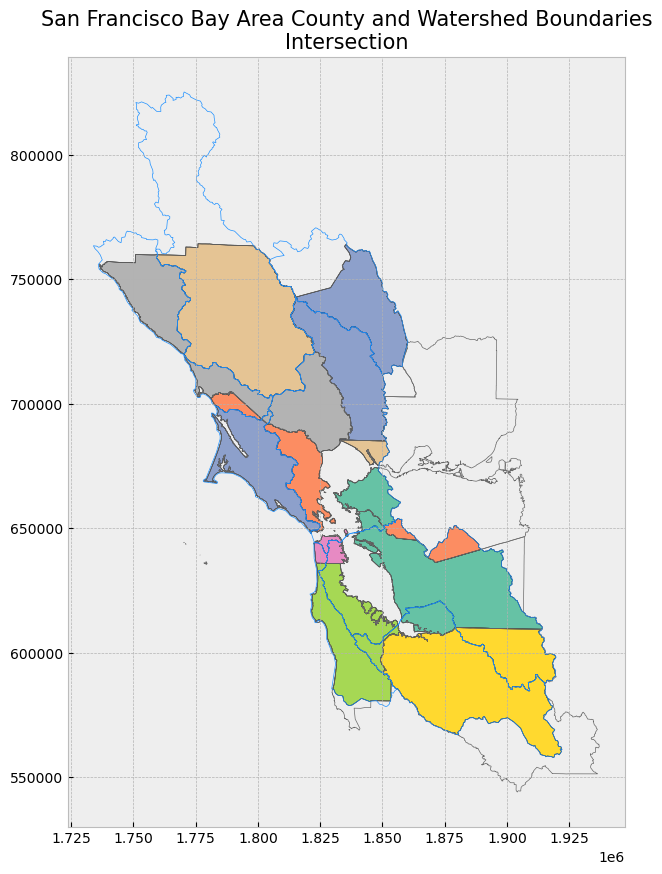

In [13]:
# Get intersection
intersection_result = gpd.overlay(counties, watersheds, how = 'intersection')

# Print head and tail of attribute table
display_table(table_name = "Intersection", attribute_table = intersection_result)

# Plot overlay
plot_overlay(overlay_type = "Intersection", overlay_result = intersection_result)

### Identity

With `how='identity'`, data from both layers are combined, but only the geometries that are unique to the first dataset or are covered by both datasets are kept. Any geometries unique to the second dataset (no overlapping with the first dataset) are discarded. [^gpd_set]

```{figure} ../_static/img/vector_identity.jpg
:name: Identity of the geometries keeps the geometries covered by the first dataset or both datasets.
Identity keeps the geometries of the first dataset. Any intersecting geometries from the second dataset are also combined and included. In the figure, all of A and the portion of B that intersects A are kept.
```

Looking at the attribute table, the fields from the individual datasets have been combined. For those geometries unique to the first dataset, the fields that came from the second dataset have `NaN` as values.

Looking at the map, we see all combined geometries except for the areas that are unique to the second dataset (watershed boundaries dataset).

Attribute Table: Identity

Table shape (rows, columns): (37, 3)

First two rows:


/tmp/ipykernel_1445/1037757824.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  identity_result = gpd.overlay(counties, watersheds, how = 'identity')


,coname,CUNAME,geometry
0,Alameda County,SAN_PABLO_BAY,"POLYGON ((1844333.772 657330.481, 1844341.139 ..."
1,Alameda County,SAN_FRANCISCO_BAY,"MULTIPOLYGON (((1842804.963 642171.499, 184280..."



Last two rows:


,coname,CUNAME,geometry
35,Solano County,NaN,"MULTIPOLYGON (((1875488.683 673062.075, 187548..."
36,Sonoma County,NaN,"MULTIPOLYGON (((1804663.401 758088.289, 180471..."


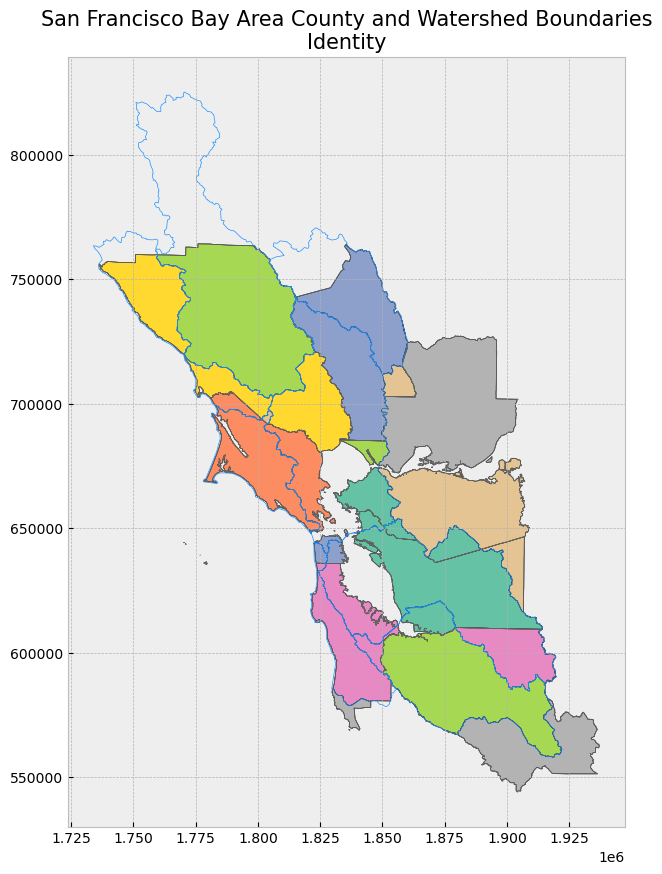

In [14]:
# Get identity
identity_result = gpd.overlay(counties, watersheds, how = 'identity')

# Print head and tail of attribute table
display_table(table_name = "Identity", attribute_table = identity_result)

# Plot overlay
plot_overlay(overlay_type = "Identity", overlay_result = identity_result)

### Difference (Erase)

With `how='difference'`, the areas covered by the second dataset is used to "cut out" or erase those corresponding areas in the first dataset. In other words, only the areas in the first dataset that do not overlap with the second dataset are kept. [^gpd_set], [^bolstad]

```{figure} ../_static/img/vector_erase.jpg
:name: Difference or Erase removes the geometries of the first dataset from the second dataset.
Difference (erase) removes geometries that intersect with each other. In the figure above, B is used to cut out and remove a portion of A.
```

Looking at the attribute table, the fields from the second dataset do not appear in the combined dataset. The second dataset was "combined" with the first dataset by discarding some data (altering the geometry) from the first dataset.

Looking at the map, we only see areas of the first dataset (county dataset) that are not covered by the second dataset (watershed boundaries dataset).

Attribute Table: Difference

Table shape (rows, columns): (9, 2)

First two rows:


/tmp/ipykernel_1445/1761870941.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  difference_result = gpd.overlay(counties, watersheds, how = 'difference')


,coname,geometry
0,Alameda County,"MULTIPOLYGON (((1864895.796 644294.887, 186520..."
1,Contra Costa County,"MULTIPOLYGON (((1905610.501 667347.414, 190571..."



Last two rows:


,coname,geometry
7,Solano County,"MULTIPOLYGON (((1875488.683 673062.075, 187548..."
8,Sonoma County,"MULTIPOLYGON (((1804663.401 758088.289, 180471..."


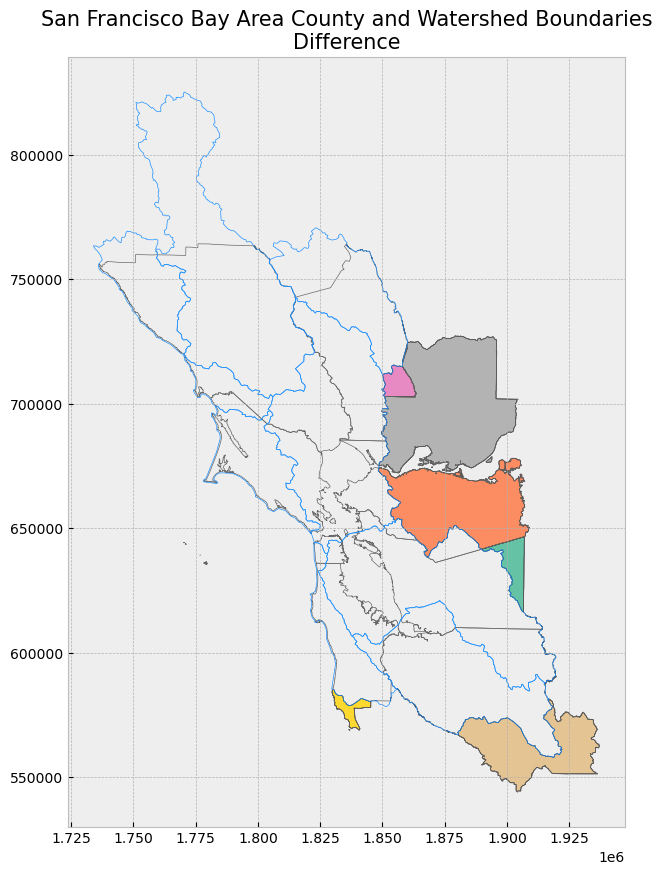

In [15]:
# Get difference
difference_result = gpd.overlay(counties, watersheds, how = 'difference')

# Print head and tail of attribute table
display_table(table_name = "Difference", attribute_table = difference_result)

# Plot overlay
plot_overlay(overlay_type = "Difference", overlay_result = difference_result)

## Merge

### Spatial Join

With spatial join, attributes from one dataset are appended to those in another dataset based on a specified relative spatial relationship. [^gpd_merge], [^esri_join]

In `geopandas`, we use the `sjoin()` function. In addition to passing the datasets as arguments, and we also pass arguments for two parameters `op` and `how`. The `op` parameter specifies the spatial relationship needed in order for the attributes of one feature to be joined to another. [^gpd_merge]

The following spatial relationships are available in `geopandas`:

| Spatial Relationship | Description |
| :------------ | ----------------------------------: |
| `contains` | geometry's points are not to the exterior of the other geometry, provided that the geometry's interior contains at least one point of the other geometry's interior |
| `crosses` | geometry's interior intersects that of the other geometry, provided that the geometry does not contain the other and the dimension of the intersection is less than the dimension of either geometry |
| `intersects` | geometry's boundary or interior touches or crosses any part of the other geometry |
| `overlaps` | geometry shares at least one point, but not all points, with the other geometry, provided that the geometries and the intersection of their interiors all have the same dimensions |
| `touches` | geometry shares at least one point with the other geometry, provided that no part of the geometry's interior intersects with the other geometry |
| `within` | geometry is enclosed in the other geometry (geometry's boundary and interior intersects with the other geometry's interior only) |

```{note}
These relationships are defined from the first dataset to the second dataset (for example, `contains` specifies that a feature from the first dataset must contain a feature from the second dataset for a join to occur).
```

```{warning}
Depending on the argument specified in the `op` parameter, a geometry that falls directly on the boundary of another geometry may be counted, may be counted twice, or may not be counted at all. For example, if a point falls on a boundary between two geometries, `predicate = "intersects"` will count that point twice and allocate (join) it to both geometries that share the boundary, whereas `predicate = "within"` will not count or allocate the point at all.
```

Just like regular table joins, there are multiple types of spatial joins, which determine which features from both datasets are kept in the output dataset. This is specified using the `how` parameter. [^gpd_merge], [^esri_join]

| Join Type | Description |
| :----------- | -------------------------------: |
| `left` | all features from the first or left dataset are kept, regardless if the feature met the specified spatial relationship criteria for a join/regardless if there is a match |
| `right` |  all features from the second or right dataset are kept, regardless if the feature met the specified spatial relationship  for a join |
| `inner` | only features from both datasets that met the spatial relationship and were joined are kept; the geometries from the first or left dataset are used for the join |

We'll illustrate this geoprocessing using the county boundaries shapefile and the well locations shapefile. Let's quickly examine the wells attribute table and plot both datasets.

Attribute Table: San Francisco Bay Area and Surrounding Area Wells

Table shape (rows, columns): (6037, 5)

First two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
0,2400064-001,Public Supply,Single Well,0,POINT (1968290.923 592019.918)
1,2400099-001,Public Supply,Single Well,0,POINT (1969113.543 595876.691)



Last two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
6035,None,Unknown,Unknown,0,POINT (1960933.648 610295.428)
6036,06S02W34B006,Observation,Single Well,152,POINT (1861394.207 597916.983)


Text(0.5, 1.0, 'San Francisco Bay Area County Boundaries and Well Locations')

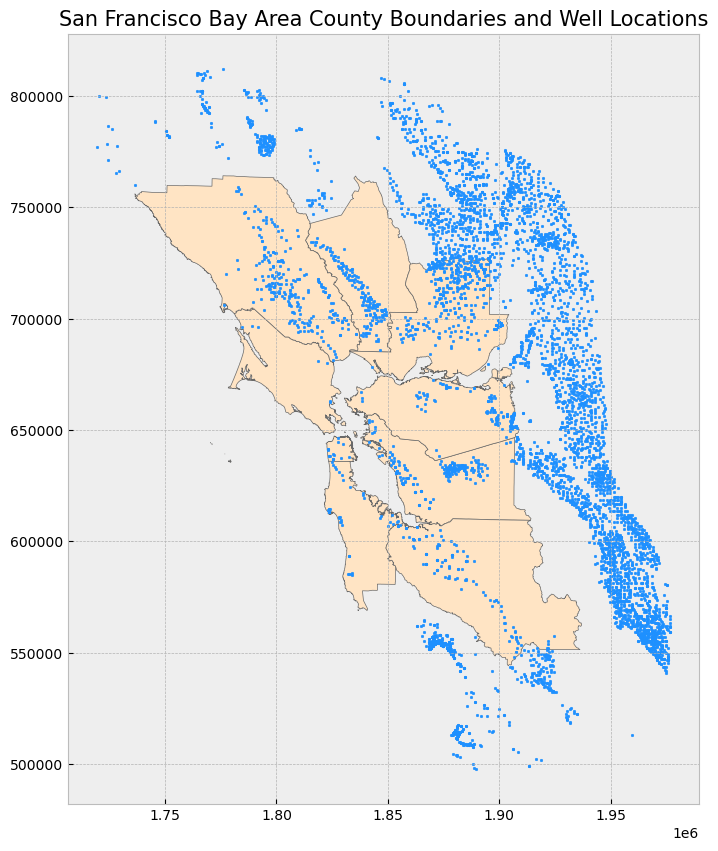

In [16]:
# Print head and tail of attribute table
display_table(table_name = "San Francisco Bay Area and Surrounding Area Wells", attribute_table = wells)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
wells.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('San Francisco Bay Area County Boundaries and Well Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

#### Left Join

We'll first demonstrate a left join. Notice that all features from the left dataset (wells dataset) are kept. The features that did not meet the spatial relationship criteria for a join have `NaN` as values for the fields that originated from the right dataset (county boundaries dataset).

Attribute Table: Left Join

Table shape (rows, columns): (6037, 7)

First two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry,index_right,coname
0,2400064-001,Public Supply,Single Well,0,POINT (1968290.923 592019.918),NaN,NaN
1,2400099-001,Public Supply,Single Well,0,POINT (1969113.543 595876.691),NaN,NaN



Last two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry,index_right,coname
6035,None,Unknown,Unknown,0,POINT (1960933.648 610295.428),NaN,NaN
6036,06S02W34B006,Observation,Single Well,152,POINT (1861394.207 597916.983),6.0,Santa Clara County


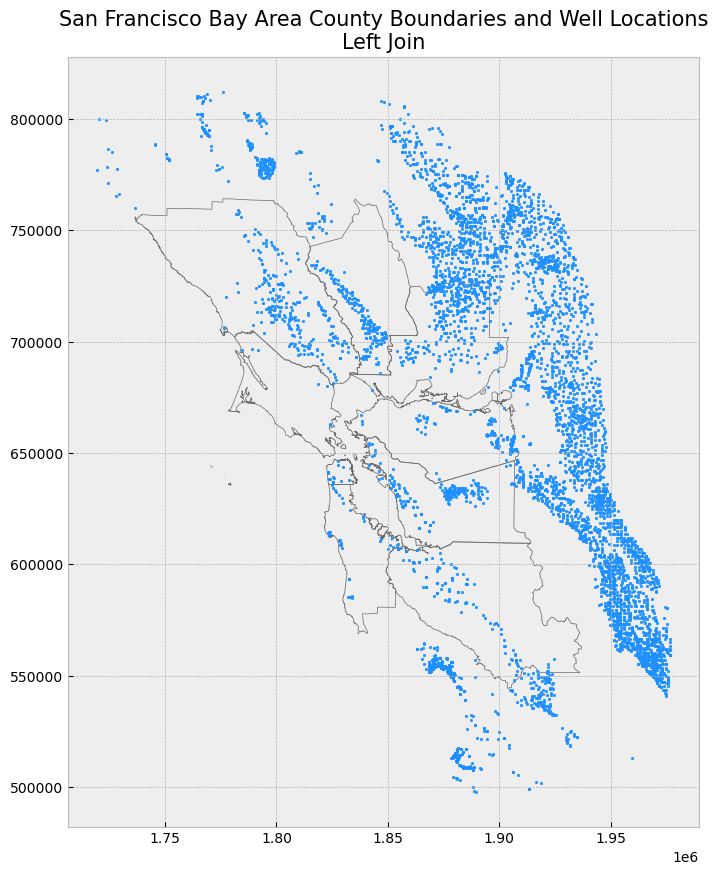

In [17]:
# Get inner join
left_join_result = gpd.sjoin(wells, counties, how = "left", predicate = 'within')

# Print head and tail of attribute table
display_table(table_name = "Left Join", attribute_table = left_join_result)

# Plot merge
plot_merge(merge_type = "Left Join", merge_result = left_join_result, merge_vector = "point")

#### Right Join

For a right join, all features from the right dataset (county boundaries dataset) are kept but are repeated multiple times. This is because a "new" county feature is created for every well point that falls within a county's boundary. As a result, because wells must fall within the county boundaries for a join to occur on the county boundaries feature, there are no resulting features with `NaN` as values in the attribute table.

```{attention} The results here are a bit useless, since it's just each county boundary multiplied by the number of wells in that county, but we kept this example for comprehensiveness.
```

In [ ]:
# Get inner join
right_join_result = gpd.sjoin(wells, counties, how = "right", predicate = 'within')

# Print head and tail of attribute table
display_table(table_name = "Right Join", attribute_table = right_join_result)

# Plot merge
plot_merge(merge_type = "Right Join", merge_result = right_join_result, merge_vector = "polygon")

Attribute Table: Right Join

Table shape (rows, columns): (1337, 7)

First two rows:


,index_left,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,coname,geometry
0,131,None,Irrigation,Unknown,211,Alameda County,"MULTIPOLYGON (((1860234.837 612219.122, 186007..."
0,132,None,Irrigation,Unknown,92,Alameda County,"MULTIPOLYGON (((1860234.837 612219.122, 186007..."



Last two rows:


,index_left,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,coname,geometry
8,5606,None,Residential,Unknown,70,Sonoma County,"MULTIPOLYGON (((1746855.532 743026.706, 174685..."
8,5925,07N09W01C001M,Residential,Single Well,110,Sonoma County,"MULTIPOLYGON (((1746855.532 743026.706, 174685..."


#### Inner Join

Finally, with an inner join, only the well locations that fall within the county boundaries are kept. These well locations have the county boundaries dataset appended to them. Because it's an inner join, there are no resulting features with `NaN` as values in the attribute table.

In [ ]:
# Get inner join
inner_join_result = gpd.sjoin(wells, counties, how = "inner", predicate = 'within')

# Print head and tail of attribute table
display_table(table_name = "Inner Join", attribute_table = inner_join_result)

# Plot merge
plot_merge(merge_type = "Inner Join", merge_result = inner_join_result, merge_vector = "point")

[^gpd_set]: [Set-Operations with Overlay, GeoPandas](https://geopandas.org/docs/user_guide/set_operations.html)
[^bolstad]: GIS Fundamentals: A First Text on Geographic Information Systems, 5th ed., Paul Bolstad
[^gpd_merge]: [Merging Data, GeoPandas](https://geopandas.org/docs/user_guide/mergingdata.html)
[^esri_join]: [Spatial Join (Analysis), Esri](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/spatial-join.htm)